# **Este *ipynb* está enmarcado dentro de un trabajo que busca predecir qué alumnos del departamento de Sistemas la UTN FRBA desertarán.**

Los datos disponibles se presentan en tres archivos separados.

Los registros de estas tres tablas se encuentran relacionados a través de un ID anonimizado que corresponde a un estudiante en particular. 

En este **ipynb** se preprocesan los datos disponibles hasta llegar a unificarlos en una sola tabla, la cual denominaremos **merged_df**.


## **Aclaraciones**

Aquellas líneas de código identificadas con **" # "** fueron extraídas de la siguente fuente:
* https://github.com/sebajarem/Analisis_desercion_en_ingenieria/tree/master/desercion/munge/00_datos_01

Aquellas líneas de código identificadas con **" ## "** son de elaboración propia.

## **Definiciones**

* **Actividad​**: Se considera que un estudiante tiene ​actividad en un año determinado si: tiene alguna materia con el campo “Tipo de aprobación” distinto de “libre” ó si rindió algún final de esa u otra materia. 
 *Notar que ​actividad es una característica siempre asociada a un año determinado ​XX​.*
---
* (ALF) **Año Lectivo Final**​: Año que se toma como punto de partida para analizar HACIA ATRÁS las historias disponibles hasta 2008. En nuestro caso, por ahora, **ALF = 2016**. 
---
* (ALI) **Año Lectivo Inicial**: Año a partir de que contamos con datos. En nuestro caso, por ahora; **ALI = 2008**. 
---
* (AUA) **Año de Última Actividad​**: Último año en que el estudiante haya tenido alguna actividad​. 
---
* (AI) **Año de Ingreso**​: Año en el que el estudiante haya realizado su primera actividad.
---
* **Alumno ​activo a la fecha ​XX**​: Se considera que un estudiante está “activo a la fecha ​XX​” si en el año ​XX ​registró ​actividad​.  
---
* (AE) **Año de egreso**​: Año en que aprobó “Proyecto Final”.  
---
* **Condición de Egresado​**: La condición de ​egresado se puede asignar a un alumno en el año de egreso o posteriores. *Ver que se necesita indicar un año para ver si pertenece a esa categoría.* 
---
* **Condición de Desertor**​: Se considera que un alumno es desertor para el año ​XX si **no** registra actividad ni en el año ​XX ni en el año ​XX - 1​. *Ver que se necesita indicar un año para ver si pertenece a esa categoría.*
---

## **Importación de librerías**





In [ ]:
## Importamos librerías para manipulación de datos.
import pandas as pd
import numpy as np

In [ ]:
  ## Elemento diferencial respecto al análisis realizado por el GIAR en 2020 ##

## Importo librerías para calcular distancias entre ciudadades.

from geopy.geocoders import GoogleV3
from geopy import distance

## Importo librearía para transformar una variable catogórica en numérica.
from sklearn.preprocessing import LabelEncoder

## **Defino años para el análisis**

In [ ]:
ALF = 2016 ## Año lectivo final
ALI = 2008 ## Año lectivo inicial

#Seteo el ano sobre el que voy a medir
ano = 2017

## **Google Colaboratory o Local**
El notebook podrá ser corrido tanto localmente como en Google Colaboratory.

El usuario deberá modificar el root path de acuerdo a su conveniencia.


In [ ]:
## Verificamos si estamos corriendo el noteboock en Google Colaboratory.
var_google_colab = 'google.colab' in str(get_ipython())
print(var_google_colab)

## En el caso de estar en Google Colab, montamos nuestro Drive.
if var_google_colab:
  from google.colab import drive
  drive.mount('/content/gdrive',force_remount=True)
  ## Direccion root donde está el notebook.
  root_path = "/content/gdrive/MyDrive/Colab Notebooks/GIAR/"

## En el caso de no estar en Google Colab, estamos corriendo localmente el notebook.
else:
  root_path = ""

## **Datasets**

In [ ]:
## Importamos el dataset Datos-Alumnos-SIGA con los registros ya clasificados (variable a predecir "deserto" incorporada).
alumnos = pd.read_csv(root_path + 'datos/alumnos_desertores.csv')

In [ ]:
## Importamos el dataset Cursadas-Alumnos-SIGA.
cursadas = pd.read_csv(root_path + 'datos/Cursadas-Alumnos-SIGA.csv')

In [ ]:
## Importamos el dataset Finales-Alumnos-SIGA.
finales = pd.read_csv(root_path + 'datos/Finales-Alumnos-SIGA.csv')

## **PREPROSESAMIENTO DE LOS DATOS**

### **ALUMNOS** ###

#### Variables que se decidieron sacar:
- **Pais**
- **Estado Civil**


#### Variables que se van a generar:
- **EsTecnico** como una categorica que es "SI" en el caso de que sea tecnico y "NO" en otro caso. Se deben respetar los nulos.
- **Distancia** como una numérica que medirá la distancia en KM que existe entre el domicilio declarado del alumno y la universidad. Dado que la FRBA cuenta con dos sedes, se fijará como locación de la misma el punto medio entre ambas sedes. En este caso, Av. Directorio 1150, CABA.
En caso que la distancia sea mayor a 70 KM, se supondrá que el dato del domicilio está desactualizado y se definirá un tratamiento particular para dicho registro. Se deben respetar los nulos.

In [ ]:
#Genero la nueva columna de esTecnico
alumnos['EsTecnico']=alumnos.apply(lambda row: 1 if row['Estudios Secundarios']=='Técnico'  else (row['Estudios Secundarios'] if pd.isnull(row['Estudios Secundarios']) else 0), axis=1)

In [ ]:
## Empezamos con el preprocesamiento para generar la nueva feature 'Distancia'.
ba_cities_with_errors = ['Monte Grande','Burzaco','CARMEN DE ARECO','Caseros','CHIVILCOY','Ciudad Evita','Ciudad Jardín Lomas del Palomar','Ciudadela','Claypole','CORONEL SUÁREZ','Crucesita','DAIREAUX','Dock Sud','DOLORES','Don Torcuato Este','Don Torcuato Oeste','El Jagüel','El Palomar','El Talar','Estanislao Severo Zeballos','EZEIZA','Florencio Varela','Florida','Florida Oeste','Francisco Alvarez','GENERAL BELGRANO','GENERAL JUAN MADARIAGA','GENERAL LAS HERAS','General Pacheco','GENERAL PINTO','GENERAL PUEYRREDÓN','GENERAL RODRÍGUEZ','GENERAL SAN MARTÍN','GENERAL VILLEGAS','Gerli','Glew','González Catán','Grand Bourg','Gregorio de Laferrere','GUAMINÍ','Guillermo E. Hudson','Haedo','Hurlingham','Ingeniero Adolfo Sourdeaux','Isidro Casanova','ITUZAINGÓ','Ituzaingó Sur','José C. Paz','José Ingenieros','José Mármol','JUNÍN','LA COSTA','La Lucila','LA MATANZA','LA PLATA','La Reja','La Tablada','La Unión','LANÚS','Lanús Este','Lanús Oeste','LAS FLORES','LINCOLN','Libertad','LLAVALLOL','LOBOS','Loma Hermosa','Lomas de Zamora','Lomas del Mirador','Longchamps','Luis Guillón','Los Troncos del Talar','LUJÁN','Malvinas Argentinas','MAR CHIQUITA','MARCOS PAZ','Mariano Acosta','Martín Coronado','Martínez','MERCEDES','Merlo','Monte Chingolo','Moreno','Morón','Munro','Muñiz','NAVARRO','OLAVARRÍA','Olivos','Pablo Podestá','Paso del Rey','PEHUAJÓ','PILAR','PINAMAR','Piñeyro','Plátanos','PRESIDENTE PERON','PUÁN','Quilmes','Quilmes Oeste','Rafael Calzada','Rafael Castillo','Ramos Mejía','Remedios Escalada de San Martín','Remedios de Escalada','RIVADAVIA','Rincón de Milberg','Saenz Peña','San Antonio de Padua','SAN ANTONIO DE ARECO','SAN ANDRÉS DE GILES','SALTO','San Fernando','San Francisco Solano','San Isidro','San José','San Justo','San Miguel','SAN NICOLÁS DE LOS ARROYOS','SAN PEDRO','SAN VICENTE','Santos Lugares','Sarandí','SUIPACHA','TAPALQUÉ','Tapiales','Temperley','Tigre','Tortuguitas','TRENQUE LAUQUEN','TRES LOMAS','Tristán Suárez','Trujui','Turdera','Valentín Alsina','Vicente López','Victoria','Villa Adelina','Villa Ballester','Villa Ayacucho','Villa Bosch (Est. Juan Maria Bosch)','Villa Domínico','Villa Eduardo Madero','Villa España','Villa Fiorito','VILLA GESELL','Villa Gobernador Udaondo','Villa José León Suárez','Villa Libertad','Villa Luzuriaga','Villa Lynch','Villa Maipú','Villa Martelli','Villa Raffo','Villa San Andrés','Villa Santos Tesei','Villa Sarmiento','Virrey del Pino','Virreyes','Wilde','William C. Morris','ZÁRATE']

In [ ]:
##
caba_cities_with_errors = ['Ciudad Autónoma de Buenos Aires','PARQUE PATRICIOS','PARQUE AVELLANEDA','RECOLETA','SAN CRISTOBAL','SAN TELMO','VILLA CRESPO','VILLA GENERAL MITRE','VILLA LUGANO','VILLA LURO','VILLA PUEYRREDÓN','VILLA SANTA RITA','VILLA SOLDATI']

In [ ]:
## Correjimos ciertos valores incorrectos en la columna 'Provincia'.
alumnos['Provincia'] = alumnos.apply(lambda row: 'Buenos Aires' if (row['Localidad'] in ba_cities_with_errors) else row['Provincia'], axis=1)
alumnos['Provincia'] = alumnos.apply(lambda row: 'CABA' if (row['Localidad'] in caba_cities_with_errors) else row['Provincia'], axis=1)

In [ ]:
##
alumnos['Provincia'] = alumnos['Provincia'].replace(['CABA / Capital Federal','-- no informado --'], ['CABA',np.nan])

In [ ]:
##
alumnos['Localidad'] = alumnos['Localidad'].replace(['-- no informado --'], [np.nan])

In [ ]:
## Generamos la columna 'Domicilio' a partir de la información disponible en 'Localidad' y 'Provincia'.
alumnos['Domicilio'] = alumnos['Localidad'] + ", " + alumnos['Provincia'] + ", Argentina"
alumnos['Domicilio'].isnull().value_counts()

La carrera Ingeniería en Sistemas se cursa en ambas sedes de la facultad. Por ello, se decide definir como locación de la FRBA el punto medio entre ambas sedes. El mismo está ubicado en **Av. Directorio 1150**.

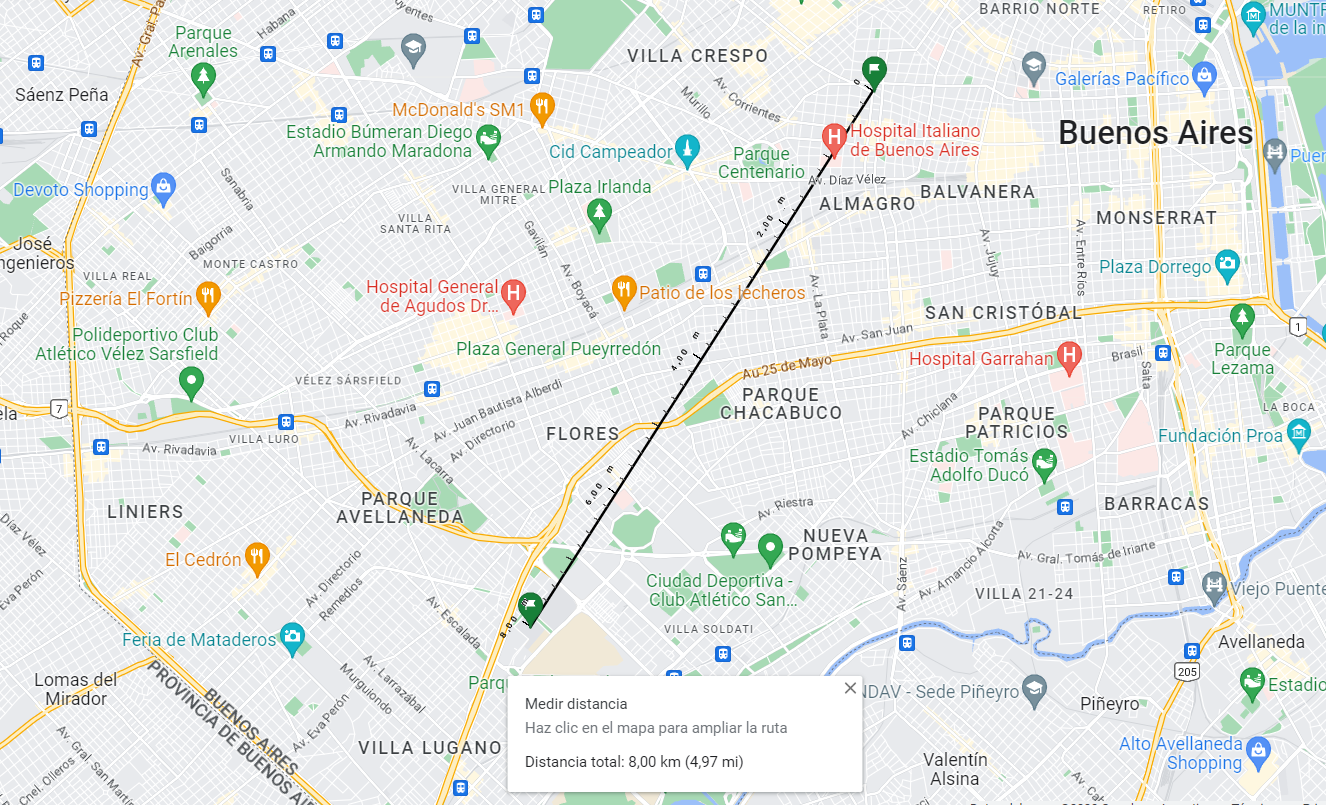

**Para aquellos alumnos que tengan domicilio en CABA, pero se desconozca el barrio de dicha ciudad en el que residen, se considerará que la distancia a la que viven es la media de la que tienen los registros con información de domicilio completo en CABA.**

La Ciudad Autónoma de Buenos Aires puede inscribirse en un círculo de 10km de radio.
La sede Medrano de la UTN.FRBA se encuentra en la zona de mayor densidad poblacional de la Ciudad Autónoma de Buenos Aires.
El punto medio entre ambas sedes se encuentra a solo 1,7 KM del centro geométrico de la ciudad y dentro de la comuna 6, una de las cuatro comunas más densamente pobladas de la capital del país. 
Estos datos nos permiten pensar que los alumnos que viven en CABA tienen mayor probabilidad de encontrarse en las zonas aledañas a la universidad y no en las periferias de la ciudad.


In [ ]:
##
uni_address = 'Av. Directorio 1150, CABA'

geocoder = GoogleV3(api_key='k')

uni = geocoder.geocode(uni_address)
location_uni = (uni.latitude, uni.longitude)

In [ ]:
## Definimos la función que se utilizará para determinar la distancia que existe entre el domicilio del alumno y lo que se definió como locación de la universidad.
def distance_uni(domicilio):
  
  city = geocoder.geocode(domicilio)

  if city == None:
    return np.nan

  else:
    return distance.great_circle((city.latitude, city.longitude), location_uni).km

In [ ]:
## Generamos la variable 'Distancia'.
alumnos['Distancia'] = alumnos['Domicilio'].apply(lambda x: distance_uni(x) if(pd.notnull(x) & (x != 'Ciudad Autónoma de Buenos Aires, CABA, Argentina')) else(0 if x == 'Ciudad Autónoma de Buenos Aires, CABA, Argentina' else x))

In [ ]:
## Guardo en un csv.
alumnos.to_csv(root_path + 'datos/alumnos_desertores_con_distancia.csv',index=False)

In [ ]:
##
alumnos['Distancia'].isnull().value_counts()

In [ ]:
##
alumnos['Localidad'].isnull().value_counts()

In [ ]:
alumnos[alumnos['Distancia']==0]['Distancia'].value_counts()

In [ ]:
dist = alumnos.loc[~((alumnos['Distancia'] == 0))]
dist['Localidad'].isnull().value_counts()

In [ ]:
dist_media = dist.groupby(['Provincia']).agg({'Distancia':['mean']})
dist_media['Provincia'] = dist_media.index
dist_media_caba = dist_media[dist_media['Provincia'] == 'CABA']['Distancia']['mean'][0]

In [ ]:
alumnos['Distancia'].replace(0, dist_media_caba, inplace = True)

In [ ]:
##
lejos = alumnos[alumnos['Distancia']>75].sort_values('Distancia', ascending = False)
lejos.shape

In [ ]:
## Generamos el dataset sin las variables que se decidieron.
alumnos_df = alumnos[['Codigo Alumno','EsTecnico','Distancia','deserto']]

### **CURSADAS** ###

#### Variables que se decidieron sacar:
- Curso
- Materia
- Departamento
- Modalidad


#### Variables que se van a generar:
- Edad al ingreso (Ano ingreso - Ano nacimiento) 
- Turno una columna por turno con la cantidad 
- Tipo de aprobación por cada una de las variables la cantidad 
- Maximo recursada por materias (existe mas de un registro por alumno y materia)
- Cantidad de veces recursada regular
- Descripción de recursada regular
- Edad en ano de ultima actividad
- Grupo ingreso nivel 1

Tener en cuenta que se debe guardar el ciclo lectivo mas actual

In [ ]:
#Filtro el set de datos por el ano en que lo quiero medir
cursadas=cursadas.loc[cursadas['Ciclo Lectivo de Cursada']<ano-2,:]

In [ ]:
## Vemos como se distribuye la variable 'Modalidad'.
cursadas['Modalidad'].value_counts()

In [ ]:
## Unificamos la denominación para hacer referencia a cursadas anuales.
cursadas['Modalidad'].replace('     1/1','Anual', inplace = True)

In [ ]:
## Identificamos nombres de materias poco frecuentes.
a = pd.DataFrame(cursadas['Materia'].value_counts())
a[a<20].dropna(how='any')

In [ ]:
## Unificamos la denominación en aquellos casos en los que se identificó que existían diferentes nombres o abreviaturas para hacer referencia a una misma materia.
cursadas['Materia'].replace('Tecnologías Avanzadas en la Construcción de Sw','Tecnologías Avanzadas en la Construcción de Software', inplace = True)
cursadas['Materia'].replace('Introducción a la Ingeniería en Software','Ingeniería en Software', inplace = True)
cursadas['Materia'].replace('Inglés (Comunicaciónal )','Inglés Comunicaciónal I', inplace = True)
cursadas['Materia'].replace('Sistemas de Información Geografica','Sistemas de Información Geografico', inplace = True)
cursadas['Materia'].replace('Autocad - Sistemas de Representación','Sistemas de Representación', inplace = True)

In [ ]:
## Generamos la variable año_alumno_uni que representa en que año de su carrera cursó el alumno la materia. 0 = primer año (ingresante), 1 = segundo año, 2 = tercer año... 
cursadas['año_alumno_uni'] = cursadas['Ciclo Lectivo de Cursada'] - cursadas['Año de ingreso']

In [ ]:
## Generamos la varaiable 'cursada' que permita identificar a todas las cursadas iguales independientemente del alumno que las curse.
cursadas['cursada'] = cursadas.apply(lambda row: (str(row['Ciclo Lectivo de Cursada'])+row['Curso']+row['Modalidad']+row['Turno']+row['Materia']), axis = 1)

In [ ]:
cursadas['cursada'].value_counts()

In [ ]:
## Asignamos a cada alumno un grupo de ingreso basándonos en su cursada de la materia integradora de primer nivel durante su año de ingresante.
cursadas['grupo_ingreso_nivel1'] = cursadas.apply(lambda row: (str(row['Ciclo Lectivo de Cursada'])+' '+row['Curso']+row['Modalidad']+' '+row['Turno']) if (row['Materia']=='Sistemas y Organizaciones' and row['año_alumno_uni']==0)  else np.nan, axis=1)

In [ ]:
## Genero un dataset en el que se guarda información referida la cursada de la materia integradora de 1er nivel.
cursadas_integradoras = cursadas[['Codigo Alumno','grupo_ingreso_nivel1']]
cursadas.drop(columns=['grupo_ingreso_nivel1'], inplace = True)

In [ ]:
## Eliminamos los registros de cursadas que no están relacionadas a la materia integradora de primer nivel cursada en primer año.
cursadas_integradoras = cursadas_integradoras.dropna(how='any')

## Agrupamos las cursadas por alumno y para aquellos casos en que el alumno haya más de un registro, decidimos quedarnos con la primera cursada.
## Los nombres de las cursadas comienzan con el año, de allí que se pueda usar min().
cursadas_integradoras = cursadas_integradoras.groupby('Codigo Alumno').min()
cursadas_integradoras.shape

In [ ]:
cursadas['Codigo Alumno'].value_counts().count()

In [ ]:
#@title
cursadas_integradoras['grupo_ingreso_nivel1'].isnull().value_counts()

In [ ]:
## Descartaremos aquellos grupos con menos de 10 alumnos registrados en todo el dataframe de cursadas.
grupos_descartar = pd.DataFrame((cursadas_integradoras['grupo_ingreso_nivel1'].value_counts() < 10))
grupos_descartar = grupos_descartar.loc[grupos_descartar['grupo_ingreso_nivel1']==True]
grupos_descartar = list(grupos_descartar.index)

cursadas_integradoras['grupo_ingreso_nivel1'].replace(grupos_descartar, np.nan, inplace = True)
cursadas_integradoras.dropna(how='any',inplace=True)

In [ ]:
## Transformamos la variable en numérica.
## Cada curso particular tendrá un número asignado.
le = LabelEncoder()
cursadas_integradoras['grupo_ingreso_nivel1'] = le.fit_transform(cursadas_integradoras['grupo_ingreso_nivel1'])

In [ ]:
cursadas_integradoras['grupo_ingreso_nivel1'].value_counts()

In [ ]:
#Genero la variable edad al ingreso
cursadas['edad al ingreso']=cursadas['Año de ingreso']-cursadas['Año de nacimiento']

#Genero la lista de las descripciones de recursadas
recursadas_df=cursadas.groupby(['Cantidad de veces recursada regular','Descripción de recursada regular'])['Materia'].max().reset_index()[['Cantidad de veces recursada regular','Descripción de recursada regular']]

#Agrupo las cursadas de cada alumno por materia y calculo la mayor cantidad de recursadas y lo uno con la descripcion de cada una
cursadas_df=cursadas.groupby(['Codigo Alumno','Materia'])['Cantidad de veces recursada regular'].max().reset_index().join(recursadas_df.set_index('Cantidad de veces recursada regular'),on='Cantidad de veces recursada regular',rsuffix='_o')

#Compruebo con un alumno si se obtuvieron los registros correctos
print(cursadas_df[cursadas_df['Codigo Alumno']==9996270])

#Setea la descripcion como categoria
cursadas_df['Descripción de recursada regular']=cursadas_df['Descripción de recursada regular'].astype('category')

#Elimino la columna materia, y agrupo por alumno y sumarizo las descripciones
recursadas_df=pd.get_dummies(cursadas_df,columns=['Descripción de recursada regular']).drop(['Materia'], axis=1).groupby(['Codigo Alumno']).sum()

In [ ]:
#Chequeo que las columnas sean las que necesito
recursadas_df.head()

In [ ]:
recursadas_df['Descripción de recursada regular_Recurso n Veces (>5)'].value_counts()

In [ ]:
#Genero las dummies que se acordaron y los valores restantes
cursadas_df=pd.get_dummies(cursadas,columns=['Turno','Tipo de aprobación','Sexo']).groupby(['Codigo Alumno']).agg({'Ciclo Lectivo de Cursada':['max'],
        'edad al ingreso':['max'],'Año de ingreso':['max'], 'Turno_Mañana':['sum'],
       'Turno_Noche':['sum'], 'Turno_Tarde':['sum'], 'Tipo de aprobación_Cambio Curso':['sum'],
        'Tipo de aprobación_Firmo':['sum'],
       'Tipo de aprobación_Libre':['sum'], 'Tipo de aprobación_No Firmo':['sum'],
       'Tipo de aprobación_Promociono':['sum']
        ,'Sexo_F':['max'],'Sexo_M':['max']})

#Corrijo los nombres de las columnas
cursadas_df.columns = [col[0] for col in cursadas_df.columns.values]

#Uno este DataFrame con el calculado con las descripciones de recursadas y lo guardo en el dataframe de cursadas
cursadas_df=cursadas_df.reset_index().join(recursadas_df,on='Codigo Alumno')

In [ ]:
## Unimos el DataFrame con el que contiene el grupo de ingreso y lo guardo.
cursadas_df=cursadas_df.join(cursadas_integradoras,on='Codigo Alumno')

In [ ]:
cursadas_df['grupo_ingreso_nivel1'].isnull().value_counts()

### **FINALES** ###

#### Columnas a sacar ####
- Materia
- Ano (Solo se usa para filtrar)


#### Variables a generar
- Promedio sobre los maximos de Nota
- Promedio sobre la nota (con aplazos)
- Cantidad de veces que aprobo
- Cantidad de veces que no aprobo
- Cantidad de veces que promociono

In [ ]:
#Filtro el set de datos por el ano en que lo quiero medir
finales=finales.loc[finales['Año']<ano-2,:]

In [ ]:
## Identificamos nombres de materias poco frecuentes.
a = pd.DataFrame(finales['Materia'].value_counts())
a[a<10].dropna(how='any')

In [ ]:
## Unificamos la denominación en aquellos casos en los que se identificó que existían diferentes nombres o abreviaturas para hacer referencia a una misma materia.
finales['Materia'].replace('Física','Física I', inplace = True)
finales['Materia'].replace('Arquitectura de Computadores','Arquitectura de Computadoras', inplace = True)

In [ ]:
##
finales['Nota'].value_counts()

In [ ]:
## Elimino los registros en los que haya notas con 0.
## finales = finales[finales.Nota != 0]

In [ ]:
#Corrijo los finales para que no haya notas con 11
finales.loc[finales['Nota']==11,['Nota']]=10
#Genero la columna de no aprobado
finales['noAprobado']=finales['Aprobado'].apply(lambda row: 1 if row==0 else 0)
#Agrupo los finales y me quedo con el promedio de las notas maximas
finales_max_df=finales.groupby(['Codigo Alumno','Materia'])['Nota'].max().reset_index().groupby(['Codigo Alumno'])['Nota'].mean().reset_index()

#Seteo el nombre a las columnas para que no se me superpongan
finales_max_df.columns=['Codigo Alumno','Nota_max_prom']

#Genero el resto de las agrupaciones sobre el set de finales
finales_df=finales.groupby(['Codigo Alumno']).agg({'noAprobado':[sum],'Aprobado':[sum],'Promociono':[sum],'Nota':['mean'],'Año':['max']})

#Corrijo los nombres de las columnas
finales_df.columns = [col[0] for col in finales_df.columns.values]

#Le agrego a los finales la columna de finales maximos agrupados
finales_df=finales_df.reset_index().join(finales_max_df.set_index('Codigo Alumno'),on='Codigo Alumno')

In [ ]:
## Agrego la columna 'Indice_aprobación', la cual se calcula como la cantidad de finales aprobados sobre el total de finales rendidos. 
finales_df['Indice_aprobacion'] = (finales_df['Aprobado'])/(finales_df['Aprobado']+finales_df['noAprobado'])

In [ ]:
finales_df.head()

### **AGRUPACIÓN de todos los registros** ###

#### merged_df

In [ ]:
#
merged_df = alumnos_df.join(cursadas_df.set_index('Codigo Alumno'),on='Codigo Alumno').join(finales_df.set_index('Codigo Alumno'),on='Codigo Alumno')

merged_df = merged_df[(merged_df['Codigo Alumno'].isin(finales_df['Codigo Alumno'])) & (merged_df['Codigo Alumno'].isin(cursadas_df['Codigo Alumno']))]

In [ ]:
## Generamos la variable 'cantidad de años', la cual indica la cantidad de años transcurridos desde que el alumno se inscribió hasta su última actividad registrada.
merged_df['cantidad de años'] = merged_df.apply(lambda row: (row['Año'] - row['Año de ingreso']) if (row['Año']>row['Ciclo Lectivo de Cursada'])  else (row['Ciclo Lectivo de Cursada'] - row['Año de ingreso']), axis=1)

In [ ]:
## Nos desprendemos de la variable 'Año de ingreso'.
merged_df.drop(['Año de ingreso'], axis=1, inplace = True)
merged_df.shape

In [ ]:
#Guardo los registros en un csv
merged_df.to_csv(root_path + 'datos/baseline_2009_completo.csv',index=False)

In [ ]:
#
merged_df['deserto'].value_counts()